## Analysis of Taxonomy
This is a script to analyze the taxonomy files (with and without abundances)

In [2]:
#import libraries in python3 kernel
import pandas as pd
import seaborn as sns
import glob
import os
import boto
import matplotlib.pyplot as plt
import numpy as np
import skbio
from Bio import SeqIO
from Bio.SeqIO.FastaIO import SimpleFastaParser
from Bio.SeqUtils import GC
from collections import defaultdict
from collections import Counter
import statistics
%matplotlib inline

Adapt manifest and metadata files
This function outputs MERGED which is a table with the metadata attached to each ASV ids along with their respetive abundances. It takes as an input:
all_merged: output of consolidate_tables.py


In [4]:
#paths to files needed as inputs for respective functions
all_merged_path = '/Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/merged_all_18s_tables.tsv'
manifestfile_path = '/Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/16S/02-PROKs/MANIFEST.tsv'
metadatafile_path = '/Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/16S/Runs_46_47_55_18years_SPOT_USC_2/METADATA_F08.tsv'
path_to_tsvs = '/Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/'
path_to_bacaro = '/Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/TD_metric/Bacaros_Beta/all18slvl4/all_18s_stagg_taxo.csv'
expected_file = 'expected_18s_staggered'
path_to_expected = '/Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/IN-SILICO/in-silico-mocks/18s_stagg_even_expected_tax.tsv'

In [27]:
def adapt_metadata(all_merged, manifestfile, metadatafile):
    df = pd.read_csv(all_merged, sep='\t')
    tables = df[['sample_name', 'feature_id', 'feature_frequency']].copy()
    tables.rename(columns={'sample_name':'file'}, inplace=True)
    manifest = pd.read_csv(manifestfile, sep='\t')
    manifest['file'] = [s.split('SPOT_USC_2/')[1] for s in manifest['absolute-filepath']]
    manifest['file'] = [s.split('.R')[0] for s in manifest['file']]
    manifest = manifest.drop(columns = ['absolute-filepath', 'direction'])
    manifest.drop_duplicates()
    merged = pd.merge(tables,manifest, on='file')
    merged = merged.drop(columns = ['file'])
    merged = merged.drop_duplicates()
    print('Set up manifest ...')
    metadata = pd.read_csv(metadatafile, sep='\t')
    merged = pd.merge(merged,metadata, on='sample-id')
    print('Set up metadata ...')
    merged.to_csv('filtering_asvs.tsv', sep = '\t')
    print('Saved filtering_asvs.tsv')
    return merged

In [28]:
merged = adapt_metadata(all_merged_path, manifestfile_path, metadatafile_path)

Set up manifest ...
Set up metadata ...
Saved filtering_asvs.tsv


In [225]:
def get_abundances(path, composition, runnumber):
    files = glob.glob('{0}*.tsv'.format(path))
    taxos = []
#    if not os.path.exists(path+composition):
#        os.mkdir(path+composition)
    for filename in files:
        tax = pd.read_csv(filename, sep='\t')
        tax['table_id'] = str(filename.split('/')[-1])
        tax["table_id"] = tax["table_id"].str.replace(".tsv", "")
        tax['Forward_trim'], tax['Reverse_trim'] = tax['table_id'].str.split('R', 1).str
        tax['Forward_trim'] = tax['Forward_trim'].map(lambda x: x.lstrip('F'))
        tax["Forward_trim"] = pd.to_numeric(tax["Forward_trim"])
        tax["Reverse_trim"] = pd.to_numeric(tax["Reverse_trim"])
        taxos.append(tax)
    print('Appended all taxonomies to taxos')
    taxos = pd.concat(taxos)
    taxos = taxos.rename(columns={"Feature ID": "feature_id"}, errors="raise")
    separated = taxos.merge(merged, how='left', on='feature_id')
    separated = separated.drop_duplicates()
    separated = separated[separated["community"] == '18S']
    separated = separated[separated["composition"] == composition]
    separated['run-number']= separated['run-number'].astype(str)
    separated = separated[separated["run-number"] == runnumber]
    separated['sum'] = separated.groupby(['table_id','sample-id'])['feature_frequency'].transform('sum')
    separated['ratio'] = separated['feature_frequency']/(separated['sum'])
   
    return separated

In [226]:
separated = get_abundances(path_to_tsvs, 'Staggered', '46')

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_91446/3719075166.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  tax["table_id"] = tax["table_id"].str.replace(".tsv", "")
/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_91446/3719075166.py:10: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  tax['Forward_trim'], tax['Reverse_trim'] = tax['table_id'].str.split('R', 1).str


Appended all taxonomies to taxos


In [13]:
def split_tx_by_sample(path, composition, runnumber, foldername):
    files = glob.glob('{0}*.tsv'.format(path))
    for filename in files:
        tax = pd.read_csv(filename, sep='\t')
        tax = tax.rename(columns={"Feature ID": "feature_id"}, errors="raise")
        new = tax.merge(merged, how='left', on='feature_id')
        new = new.drop(['Confidence', 'sample-id'], axis=1)
        new = new.drop_duplicates()
        new = new[new["community"] == '18S']
        new = new[new["composition"] == composition]
        new['run-number']= new['run-number'].astype(str)
        new = new[new["run-number"] == runnumber]
        new.to_csv(filename.split(foldername)[0]+foldername+'/'+composition+'/'+runnumber+filename.split(foldername+'/')[1], sep = '\t')
        return new

In [ ]:
split_tx_by_sample()

Once all taxonomies are in the same folder, run Bacaro's delta T measure over desired taxonomic level (1 to 7)

hm plots a heatmap of 

In [105]:
def hm(path, truthfilename):
    bacaros_dm = pd.read_csv(path)
    bacaros_dm = bacaros_dm.set_index('Unnamed: 0')
    bacaros_dm = 1  - bacaros_dm
    #bacaros_dm is a distance matrix of table X table
    my_pcoa = skbio.stats.ordination.pcoa(bacaros_dm.values)
    plt.scatter(my_pcoa.samples['PC1'],  my_pcoa.samples['PC2'])
    against_exp = bacaros_dm[[truthfilename]].copy()
    against_exp = against_exp.reset_index().rename(columns={against_exp.index.name:'sample_name'})
    against_exp.drop(against_exp.index[against_exp['sample_name'] == truthfilename], inplace=True)
    against_exp['Forward_trim'] = [s.split('R')[0] for s in against_exp['sample_name']]
    against_exp['Forward_trim'] = [s.split('46F')[1] for s in against_exp['Forward_trim']]
    against_exp['Reverse_trim'] = [s.split('R')[1] for s in against_exp['sample_name']]
    against_exp["Forward_trim"] = pd.to_numeric(against_exp["Forward_trim"])
    against_exp["Reverse_trim"] = pd.to_numeric(against_exp["Reverse_trim"])
    against_exp["Forward_trim"].replace({0: 280}, inplace=True)
    against_exp["Reverse_trim"].replace({0: 290}, inplace=True)
    tohm = against_exp.pivot("Forward_trim", "Reverse_trim", "expected_18s_staggered")
    tohm.rename({280: 'full'}, axis=0, inplace=True)
    tohm.rename({290: 'full'}, axis=1, inplace=True)
    ax = sns.heatmap(tohm, cmap=sns.color_palette("hls", 90))
    ax.invert_yaxis()
    plt.figure(figsize=(12,12))

    return (tohm, bacaros_dm)

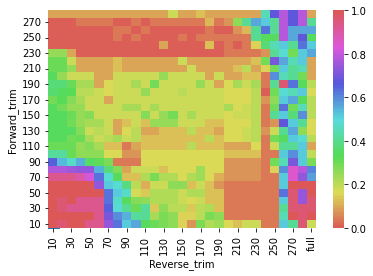

<Figure size 864x864 with 0 Axes>

In [106]:
tohm, bacaros_dm = hm(path_to_bacaro, expected_file)
#1 is very dissimilar
#0 is the same as expected

In [121]:
# get max and min values
def get_max_min(df):
    print('The min value is {0} and the max value is {1}'.format(df.at[df.stack().index[np.argmin(df.values)]], 
                                                                 minv = df.at[df.stack().index[np.argmax(df.values)]]))

Change the trim lengths to average quality scores instead using fastQC

Make plot of log expected against log observed

In [211]:
#1 load dataframe with feature frequencies and trim lengths
new = get_abundances(path_to_tsvs, 'Staggered', '46')

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_91446/1148124696.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  tax["table_id"] = tax["table_id"].str.replace(".tsv", "")
/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_91446/1148124696.py:10: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  tax['Forward_trim'], tax['Reverse_trim'] = tax['table_id'].str.split('R', 1).str


Appended all taxonomies to taxos


In [187]:
## to import the expected taxonomies and transofrm to ratios
def expected_df(path):
    expected = pd.read_csv(path, sep='\t')
    expected = expected.rename(columns={'silva_taxonomy':'Taxon', 'sample-id': 'Replicate'})
    expected_even = expected[expected.mock_even_insilico != 0]
    expected_even = expected_even.drop(columns=['mock_staggered_insilico','taxonomy'])
    expected_even.reset_index(drop=True, inplace=True)
    expected_even['expected_ratio'] = expected_even['mock_even_insilico']/(expected_even['mock_even_insilico'].sum())
    expected_stagg = expected.drop(columns=['mock_even_insilico','taxonomy'])
    expected_stagg.reset_index(drop=True, inplace=True)
    expected_stagg['expected_ratio'] = expected_stagg['mock_staggered_insilico']/(expected_stagg['mock_staggered_insilico'].sum())
    
    return (expected_even, expected_stagg)

In [188]:
expeven, expstagg = expected_df(path_to_expected)

In [227]:
compr_obs_exp = expstagg.merge(separated, how='left', on='Taxon')

In [228]:
compr_obs_exp = compr_obs_exp.rename(columns={'sample-id': 'Replicate'})

In [243]:
f220r220 = compr_obs_exp[compr_obs_exp.table_id == 'F220R220']
f220r210 = compr_obs_exp[compr_obs_exp.table_id == 'F220R210']
f230r60 = compr_obs_exp[compr_obs_exp.table_id == 'F230R60']

In [ ]:
above_200 = compr_obs_exp[compr_obs_exp["Forward_trim"] > 200]
above_200 = above_200[above_200["Reverse_trim"] > 200]

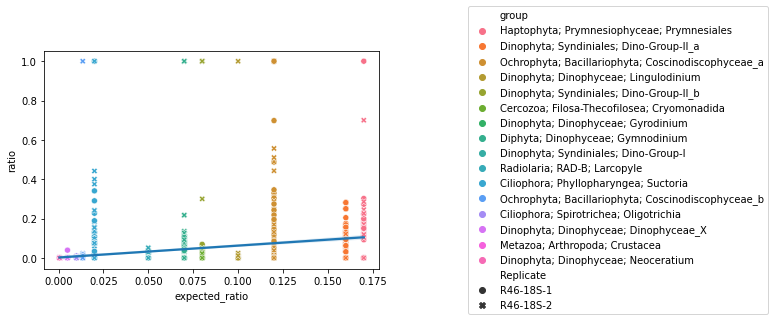

In [233]:
#if i only include some good tables
g = sns.scatterplot(data=above_200, x="expected_ratio", y="ratio", hue="group", style='Replicate')
#the sample id is replicate name
sns.regplot(data=above_200, x="expected_ratio", y="ratio", scatter=False, ax=g)
#sns.regplot(data=f220r220, x="expected_ratio", y="ratio", scatter=False, ax=g)
#sns.regplot(data=f220r210, x="expected_ratio", y="ratio", scatter=False, ax=g)

g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

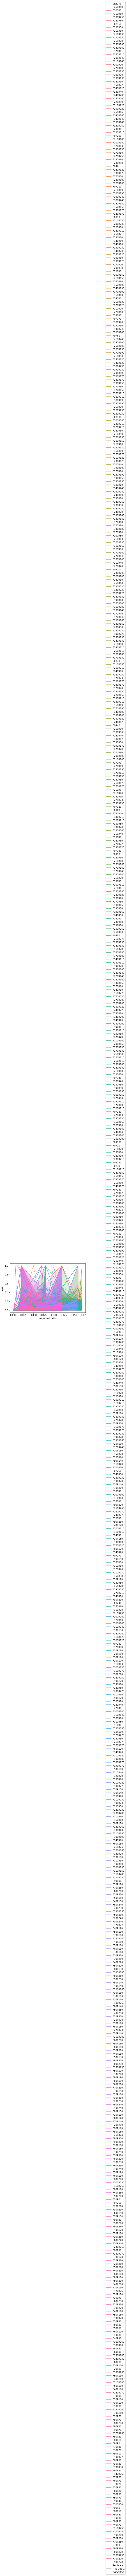

In [223]:
#if i include all the tables
g = sns.lineplot(data=compr_obs_exp, x="expected_ratio", y="ratio", hue="table_id", style='Replicate')
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

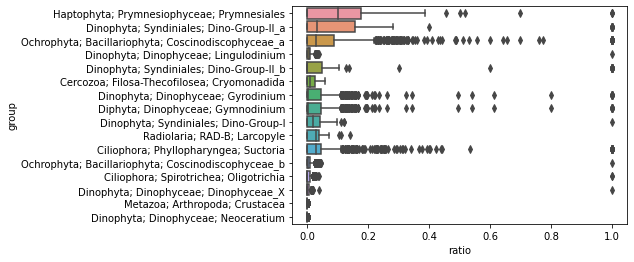

In [242]:
# generate a boxplot to see the data distribution by treatments. Using boxplot, we can 
# easily detect the differences between different treatments
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.boxplot(x='ratio', y='group', data=compr_obs_exp)
#ax.tick_params(axis='x', labelrotation=90)
plt.show()

### compare each group against expected

In [ ]:
#this is from alex
#Create an iterable of all the table_id X replicate combos
pairs = it.product(df['table_id'].unique(), df['Replicate'].unique())

#We'll keep a list of dicts.
results = []
for pair in pairs:
    t_id = pair[0] #the table id
    rep = pair[1] #the replicate
    
    #Filter the dataframe. 
    arr = df[(df['table_id'] == t_id) & (df['Replicate'] == rep)]['ratio'].values
    #Make a single "record" containing the table id, replicate, and ratio array.
    results.append({'table_id': t_id,
                    'replicate': rep,
                    'ratios': arr})
    
# now we can make a dataframe from the list of dicts.
r = pd.DataFrame.from_records(results)

#example: Compute a new column based on the array values
means = []
for i, row in r.iterrows():
    means.append(row['ratios'].mean())
    
r['Mean'] = means
r